# 1 - DEFINIÇÃO BIBLIOTECAS

In [1]:
import pyodbc
import pandas as pd
import json
import smtplib
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText
from email.mime.base import MIMEBase
from email.mime.image import MIMEImage
from email import encoders

# 2 - LEITURA DO JSON DE PARAMETRIZAÇÃO

In [2]:

paramJson 	= "/Notebook/Config/config.json"
file 		= open(paramJson)
dfJson 		= json.load(file)


for tag in dfJson:
    server 		= dfJson[tag]['server']
    database 	= dfJson[tag]['database']
    username 	= dfJson[tag]['username']
    password 	= dfJson[tag]['password']
    fromaddr 	= dfJson[tag]['fromaddr']
    toaddr 		= dfJson[tag]['toaddr']
    chave 		= dfJson[tag]['chave']
    subject 	= dfJson[tag]['subject']
    filename 	= dfJson[tag]['filename']
    file 		= dfJson[tag]['file']
    image 		= dfJson[tag]['image']
    


# 3 - CONEXÃO COM SQL SERVER

In [3]:
cnxn 	= pyodbc.connect('DRIVER={SQL Server};SERVER='+server+\
                      ';DATABASE='+database+\
                      ';UID='+username+\
                      ';PWD='+ password)

cursor 	= cnxn.cursor()


query 	= """
SELECT AbrGrupo
, NomPacote
, CONVERT(VARCHAR(10), DthInicio, 103) + ' ' + CONVERT(VARCHAR(10), DthInicio, 108) DthInicio
, CONVERT(VARCHAR(10), DthFim, 103) + ' ' + CONVERT(VARCHAR(10), DthFim, 108) DthFim
, DATEDIFF(SECOND,DthInicio,DthFim) NumTmpProcessamento 
, CASE WHEN TpoExecucao = 'I' THEN 'EM PROCESSAMENTO'
 WHEN TpoExecucao = 'E' THEN 'PROCESSAMENTO COM ERRO/EXPUGO'
  WHEN TpoExecucao = 'F' THEN 'PROCESSADO COM SUCESSO'
  END DscStatus

FROM dbo.TB_Carga

WHERE NomPacote NOT LIKE '%CONTROLADOR%'

ORDER BY IdCarga;
"""
df 		= pd.read_sql(query, cnxn)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


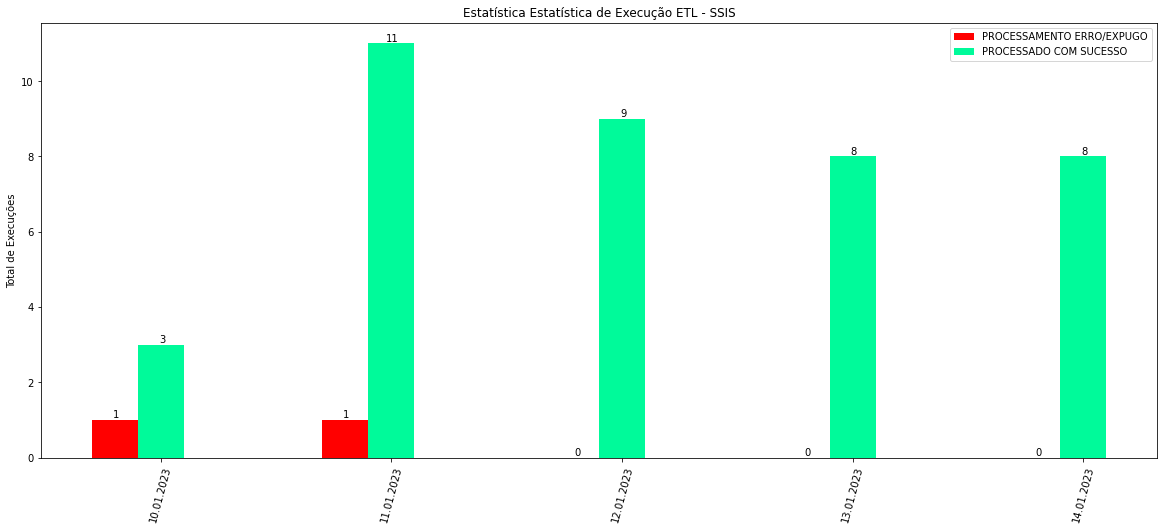

In [4]:
import numpy as np
import matplotlib.pyplot as plt

N = 5
ind = np.arange(N)
width = 0.2

fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(111)

yvals = [1,1,0,0,0]
rects1 = ax.bar(ind, yvals, width, color='#FF0000')

zvals = [3,11,9,8,8]
rects2 = ax.bar(ind+width, zvals, width, color='#00FA9A')


ax.set_ylabel('Total de Execuções')
plt.title('Estatística Estatística de Execução ETL - SSIS')
ax.set_xticks(ind+width)
ax.set_xticklabels( ('10.01.2023','11.01.2023','12.01.2023','13.01.2023','14.01.2023') )
ax.legend( (rects1[0], rects2[0]), ('PROCESSAMENTO ERRO/EXPUGO','PROCESSADO COM SUCESSO') )

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/1.9, 1.*h, '%d'%int(h),ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.xticks(rotation = 75)

plt.savefig(image)

plt.show()

plt.close()

# 4 - ENVIO E-MAIL

In [5]:

df.to_csv(file,sep=';',index=False)

msg 			= MIMEMultipart()
msg['From'] 	= fromaddr 
msg['To']		= toaddr 
msg['Subject'] 	= subject
filename 		= filename

msg.attach(MIMEText('Bom dia! Segue em anexo o relatório com os pacotes que apresentaram falha no processamento. <p><p> <img src="cid:image1"><p><p> Atenciosamente, <p><p>Monitoramento Jobs', 'html'))
image = MIMEImage(open(image, 'rb').read())
attachment = open(file, "rb")
p = MIMEBase('application', 'octet-stream')
p.set_payload((attachment).read())
encoders.encode_base64(p)
image.add_header('Content-ID', '<image1>')
msg.attach(image)
p.add_header('Content-Disposition', "attachment; filename= %s" % filename)
msg.attach(p)
s = smtplib.SMTP('smtp.gmail.com', 587)
s.starttls()
s.login(fromaddr, chave)
text = msg.as_string()
s.sendmail(fromaddr, toaddr, text)
s.quit() 

(221,
 b'2.0.0 closing connection i8-20020a056871028800b0014c83629498sm12309812oae.43 - gsmtp')